In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time

from slim.datasets import dataset_utils
from slim.datasets import flowers

# Main slim library
from tensorflow.contrib import slim

In [18]:
def regression_model(inputs, is_training=True, scope="deep_regression"):
    """Creates the regression model.

    Args:
        inputs: A node that yields a `Tensor` of size [batch_size, dimensions].
        is_training: Whether or not we're currently training the model.
        scope: An optional variable_op scope for the model.

    Returns:
        predictions: 1-D `Tensor` of shape [batch_size] of responses.
        end_points: A dict of end points representing the hidden layers.
    """
    with tf.variable_scope(scope, 'deep_regression', [inputs]):
        end_points = {}
        # Set the default weight _regularizer and acvitation for each fully_connected layer.
        with slim.arg_scope([slim.fully_connected],
                            activation_fn=tf.nn.relu,
                            weights_regularizer=slim.l2_regularizer(0.01)):

            # Creates a fully connected layer from the inputs with 32 hidden units.
            net = slim.fully_connected(inputs, 32, scope='fc1')
            end_points['fc1'] = net

            # Adds a dropout layer to prevent over-fitting.
            net = slim.dropout(net, 0.8, is_training=is_training)

            # Adds another fully connected layer with 16 hidden units.
            net = slim.fully_connected(net, 16, scope='fc2')
            end_points['fc2'] = net

            # Creates a fully-connected layer with a single hidden unit. Note that the
            # layer is made linear by setting activation_fn=None.
            predictions = slim.fully_connected(net, 1, activation_fn=None, scope='prediction')
            end_points['out'] = predictions

            return predictions, end_points

In [19]:
with tf.Graph().as_default():
    # Dummy placeholders for arbitrary number of 1d inputs and outputs
    inputs = tf.placeholder(tf.float32, shape=(None, 1))
    outputs = tf.placeholder(tf.float32, shape=(None, 1))

    # Build model
    predictions, end_points = regression_model(inputs)

    # Print name and shape of each tensor.
    print("Layers")
    for k, v in end_points.items():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))

    # Print name and shape of parameter nodes  (values not yet initialized)
    print("\n")
    print("Parameters")
    for v in slim.get_model_variables():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))

Layers
name = deep_regression/fc1/Relu:0, shape = (?, 32)
name = deep_regression/fc2/Relu:0, shape = (?, 16)
name = deep_regression/prediction/BiasAdd:0, shape = (?, 1)


Parameters
name = deep_regression/fc1/weights:0, shape = (1, 32)
name = deep_regression/fc1/biases:0, shape = (32,)
name = deep_regression/fc2/weights:0, shape = (32, 16)
name = deep_regression/fc2/biases:0, shape = (16,)
name = deep_regression/prediction/weights:0, shape = (16, 1)
name = deep_regression/prediction/biases:0, shape = (1,)


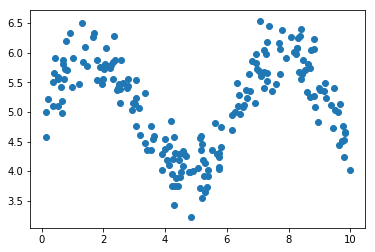

In [20]:
def produce_batch(batch_size, noise=0.3):
    xs = np.random.random(size=[batch_size, 1]) * 10
    ys = np.sin(xs) + 5 + np.random.normal(size=[batch_size, 1], scale=noise)
    return [xs.astype(np.float32), ys.astype(np.float32)]

x_train, y_train = produce_batch(200)
x_test, y_test = produce_batch(200)
plt.scatter(x_train, y_train)

In [21]:
def convert_data_to_tensors(x, y):
    inputs = tf.constant(x)
    inputs.set_shape([None, 1])
    
    outputs = tf.constant(y)
    outputs.set_shape([None, 1])
    return inputs, outputs

In [24]:
# The following snippet trains the regression model using a mean_squared_error loss.
ckpt_dir = '/tmp/regression_model/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    inputs, targets = convert_data_to_tensors(x_train, y_train)

    # Make the model.
    predictions, nodes = regression_model(inputs, is_training=True)

    # Add the loss function to the graph.
    loss = tf.losses.mean_squared_error(labels=targets, predictions=predictions)
    
    # The total loss is the uers's loss plus any regularization losses.
    total_loss = slim.losses.get_total_loss()

    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.005)
    train_op = slim.learning.create_train_op(total_loss, optimizer) 

    # Run the training inside a session.
    final_loss = slim.learning.train(
        train_op,
        logdir=ckpt_dir,
        number_of_steps=5000,
        save_summaries_secs=5,
        log_every_n_steps=500)
    
print("Finished training. Last batch loss:", final_loss)
print("Checkpoint saved in %s" % ckpt_dir)

Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 500: loss = 0.5338 (0.00 sec/step)
INFO:tensorflow:global step 1000: loss = 0.3140 (0.00 sec/step)
INFO:tensorflow:global step 1500: loss = 0.2470 (0.00 sec/step)
INFO:tensorflow:global step 2000: loss = 0.2165 (0.00 sec/step)
INFO:tensorflow:global step 2500: loss = 0.1969 (0.00 sec/step)
INFO:tensorflow:global_step/sec: 537.335
INFO:tensorflow:global step 3000: loss = 0.1880 (0.00 sec/step)
INFO:tensorflow:global step 3500: loss = 0.1836 (0.00 sec/step)
INFO:tensorflow:global step 4000: loss = 0.1897 (0.00 sec/step)
INFO:tensorflow:global step 4500: loss = 0.1801 (0.00 sec/step)
INFO:tensorflow:global step 5000: loss = 0.1780 (0.00 sec/step)
INFO:tensorflow:

In [2]:
# Located in '/private/tmp/flowers/flowers.tar.gz'
url = "http://download.tensorflow.org/data/flowers.tar.gz"
flowers_data_dir = '/tmp/flowers'

if not tf.gfile.Exists(flowers_data_dir):
    tf.gfile.MakeDirs(flowers_data_dir)

#dataset_utils.download_and_uncompress_tarball(url, flowers_data_dir)

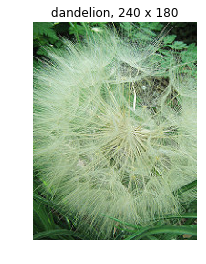

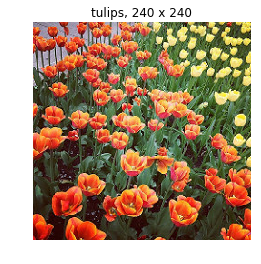

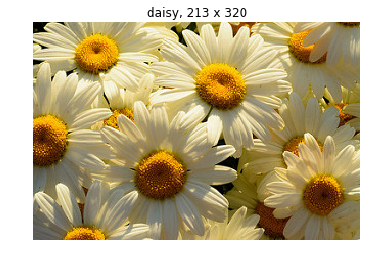

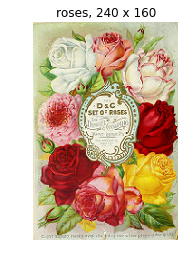

In [3]:
with tf.Graph().as_default(): 
    dataset = flowers.get_split('train', flowers_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(4):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

In [4]:
url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

#dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

In [6]:
import numpy as np
import os
import tensorflow as tf

try:
    import urllib2
except ImportError:
    import urllib.request as urllib

from slim.datasets import imagenet
from slim.nets import inception
from slim.preprocessing import inception_preprocessing

from tensorflow.contrib import slim

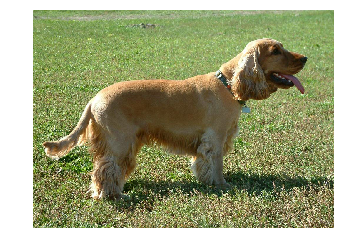

Probability 45.14% => [cocker spaniel, English cocker spaniel, cocker]
Probability 21.55% => [Sussex spaniel]
Probability 10.37% => [Irish setter, red setter]
Probability 5.06% => [Welsh springer spaniel]
Probability 2.99% => [clumber, clumber spaniel]


In [11]:
image_size = inception.inception_v1.default_image_size

with tf.Graph().as_default():
    url = 'https://upload.wikimedia.org/wikipedia/commons/7/70/EnglishCockerSpaniel_simon.jpg'
    image_string = urllib2.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(processed_images, num_classes=1001, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
        slim.get_model_variables('InceptionV1'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index]))

In [16]:
def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

In [17]:
# Note that this may take several minutes.

import os

from slim.datasets import flowers
from slim.nets import inception
from slim.preprocessing import inception_preprocessing

from tensorflow.contrib import slim
image_size = inception.inception_v1.default_image_size


def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
      variables_to_restore)


train_dir = '/tmp/inception_finetuned/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=2)
  
print('Finished training. Last batch loss %f' % final_loss)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 1: loss = 1.9945 (29.52 sec/step)
INFO:tensorflow:global step 2: loss = 2.8071 (19.38 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
Finished training. Last batch loss 2.807074


In [24]:
import tensorflow as tf
import numpy as np

In [2]:
node1 = tf.constant(3.0, dtype=tf.float32)
node2 = tf.constant(4.0)
print(node1, node2)

(<tf.Tensor 'Const:0' shape=() dtype=float32>, <tf.Tensor 'Const_1:0' shape=() dtype=float32>)


In [3]:
sess = tf.Session()
print(sess.run([node1, node2]))

[3.0, 4.0]


In [4]:
node3 = tf.add(node1, node2)
sess.run(node3)

7.0

In [6]:
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
c = a + b
sess.run(c, {a: [5.0, 2], b: [7.0, 9]})

array([ 12.,  11.], dtype=float32)

In [12]:
W = tf.Variable([0.3], dtype=tf.float32)
b = tf.Variable([-0.3], dtype=tf.float32)
x = tf.placeholder(tf.float32)
linear_model = W * x + b

In [13]:
init = tf.global_variables_initializer()
sess.run(init)

In [15]:
sess.run(linear_model, {x: [1, 2, 3, 4]})

array([ 0.        ,  0.30000001,  0.60000002,  0.90000004], dtype=float32)

In [16]:
y = tf.placeholder(tf.float32)
squared_deltas = tf.square(linear_model - y)
loss = tf.reduce_sum(squared_deltas)
print(sess.run(loss, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))

23.66


In [19]:
fixW = tf.assign(W, [-1.])
fixb = tf.assign(b, [1.])
sess.run([fixW, fixb])
print(sess.run(loss, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))

0.0


In [20]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

sess.run(init)
for i in range(1000):
    sess.run(train, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]})
    
print(sess.run([W, b]))

[array([-0.9999969], dtype=float32), array([ 0.99999082], dtype=float32)]


In [21]:
features = [tf.contrib.layers.real_valued_column('x', dimension=1)]
features

[_RealValuedColumn(column_name='x', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)]

In [22]:
estimator = tf.contrib.learn.LinearRegressor(feature_columns=features)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x114ad5ad0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


In [32]:
x_train = np.array([1., 2., 3., 4.])
y_train = np.array([0., -1., -2., -3.])

x_eval = np.array([2., 5., 8., 1.])
y_eval = np.array([-1.01, -4.1, -7., 0.])

input_fn = tf.contrib.learn.io.numpy_input_fn({'x': x_train}, y_train,
                                              batch_size=4,
                                              num_epochs=1000)

eval_input_fn = tf.contrib.learn.io.numpy_input_fn({'x': x_eval}, y_eval,
                                                   batch_size=4,
                                                   num_epochs=1000)

In [33]:
estimator.fit(input_fn=input_fn, steps=1000)

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 21 into /var/folders/l1/n4xw1wlx1h189ybkzvmjq2hc0000gn/T/tmp9LkINg/model.ckpt.
INFO:tensorflow:loss = 0.483491, step = 21
INFO:tensorflow:global_step/sec: 807.95
INFO:tensorflow:loss = 0.0578639, step = 121
INFO:tensorflow:global_step/sec: 887.083
INFO:tensorflow:loss = 0.0265847, step = 221
INFO:tensorflow:global_step/sec: 838.167
INFO:tensorflow:loss = 0.00506755, step = 321
INFO:tensorflow:global_step/sec: 770.523
INFO:tensorflow:loss = 0.00424844, step = 421
INFO:tensorflow:global_step/sec: 891.116
INFO:tensorflow:loss = 0.00188392, step = 521
INFO:tensorflow:global_step/sec: 9

LinearRegressor(params={'gradient_clip_norm': None, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x114ad5a10>, 'joint_weights': False, 'optimizer': None, 'feature_columns': [_RealValuedColumn(column_name='x', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)]})

In [34]:
train_loss = estimator.evaluate(input_fn=input_fn)
eval_loss = estimator.evaluate(input_fn=eval_input_fn)
print(train_loss)
print(eval_loss)

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-06-27-17:18:22
INFO:tensorflow:Finished evaluation at 2017-06-27-17:18:23
INFO:tensorflow:Saving dict for global step 1020: global_step = 1020, loss = 2.98375e-06
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-06-27-17:18:24
INFO:tensorflow:Finished evaluation at 2017-06-27-17:18:25
INFO:tensorflow:S

In [37]:
def model(features, labels, mode):
    W = tf.get_variable('W', [1], dtype=tf.float64)
    b = tf.get_variable('b', [1], dtype=tf.float64)
    y = W * features['x'] + b
    
    loss = tf.reduce_sum(tf.square(y - labels))
    
    global_step = tf.train.get_global_step()
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train = tf.group(optimizer.minimize(loss),
                     tf.assign_add(global_step, 1))
    
    return tf.contrib.learn.ModelFnOps(mode=mode,
                                       predictions=y,
                                       loss=loss,
                                       train_op=train)

estimator = tf.contrib.learn.Estimator(model_fn=model)

x_train = np.array([1., 2., 3., 4.])
y_train = np.array([0., -1., -2., -3.])

x_eval = np.array([2., 5., 8., 1.])
y_eval = np.array([-1.01, -4.1, -7., 0.])

input_fn = tf.contrib.learn.io.numpy_input_fn({'x': x_train}, y_train,
                                              batch_size=4,
                                              num_epochs=1000)

eval_input_fn = tf.contrib.learn.io.numpy_input_fn({'x': x_eval}, y_eval,
                                                   batch_size=4,
                                                   num_epochs=1000)

estimator.fit(input_fn=input_fn, steps=1000)
train_loss = estimator.evaluate(input_fn=input_fn)
eval_loss = estimator.evaluate(input_fn=eval_input_fn)
print(train_loss)
print(eval_loss)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x114e1b250>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l1/n4xw1wlx1h189ybkzvmjq2hc0000gn/T/tmpTS7j2P/model.ckpt.
INFO:tensorflow:loss = 22.6613268131, step = 1
INFO:tensorflow:global_step/sec: 971.704
INFO:tensorflow:loss = 0.353258446666, step = 101
INFO:tensorflow:global_step/sec: 955.84
INFO:tensorflow:loss = 0.00456345186402, step = 201
INFO:tensorflow:global_step/sec: 906.865
INFO:tenso